<a href="https://colab.research.google.com/github/bleamer/eva5/blob/master/w9-Data%20Augmentation/w9_Quiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-09-26 19:12:11.728543


In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


!pwd

In [4]:
import os
os.chdir('/content/drive/My Drive/eva5/w9-Data Augmentation/')

In [5]:
import torch                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
import torchvision
import torchvision.transforms as transforms

from model.train import train
from model.cnn import Net
from model.QuizDNN import QuizDNN
from model.resnet import ResNet18
from model.eval import val
from model.utils import cuda_init, cross_entropy_loss, sgd_optimizer, model_summary

from dataset.dataset import DS_Cifar10
from dataset.download import download_cifar10

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm



### Init Device

In [6]:
RAND_VAL = 42

TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
NUM_WORKER = 64

In [7]:
cuda, dev = cuda_init(RAND_VAL)
print(cuda, dev)

True cuda


In [8]:
!nvidia-smi --query-gpu=timestamp,gpu_name,utilization.gpu,utilization.memory --format=csv

timestamp, name, utilization.gpu [%], utilization.memory [%]
2020/09/26 19:12:12.653, Tesla T4, 0 %, 0 %


### Fetch and Check the data

In [9]:
hflip = 0.2
vflip = 0.1
rotation = 12.0

In [10]:
DS = DS_Cifar10(path='/tmp', hflip = 0.2, vflip = 0.1,rotation = 12.0)
Classes = DS.classes

Transformations
{'path': '/tmp', 'hflip': 0.2, 'vflip': 0.1, 'rotation': 12.0}
path /tmp
Files already downloaded and verified
Transformations
{'train': False, 'path': '/tmp', 'hflip': 0.2, 'vflip': 0.1, 'rotation': 12.0}
path /tmp
Files already downloaded and verified


### Data Loaders

In [11]:
train_loader = DS.loader(batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKER, cuda=cuda)
test_loader = DS.loader(train = False, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKER, cuda=cuda)

{'batch_size': 64, 'num_workers': 64, 'cuda': True}
train True
{'train': False, 'batch_size': 64, 'num_workers': 64, 'cuda': True}
train False


In [12]:
DROPOUT = 0.1
# model = Net(DROPOUT).to(dev)
model = QuizDNN().to(dev)

In [13]:
image_size = DS.image_size
model_summary(model, image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]          36,928
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]          36,928
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
        MaxPool2d-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
           Conv2d-14           [-1, 64,

In [14]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

EPOCHS = 4
LEARNING_RATE = 0.01
MOMENTUM = 0.9


losses = []
accuracies = []
incorrect_samples = []

criterion = cross_entropy_loss()  # Create loss function
optimizer = sgd_optimizer(model, LEARNING_RATE, MOMENTUM)  # Create optimizer

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = StepLR(optimizer, step_size=5, gamma=0.3)

for epoch in tqdm(range(1, EPOCHS + 1)):
    print(f'Epoch {epoch}:')
    train(model, train_loader, dev, optimizer, criterion)
    scheduler.step()
    val(model, test_loader, dev, criterion, losses, accuracies, incorrect_samples)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:


 25%|██▌       | 1/4 [00:36<01:50, 36.91s/it]


Validation set: Average loss: 0.0163, Accuracy: 6274/10000 (62.74%)

Epoch 2:


 50%|█████     | 2/4 [01:13<01:13, 36.86s/it]


Validation set: Average loss: 0.0126, Accuracy: 7201/10000 (72.01%)

Epoch 3:


 75%|███████▌  | 3/4 [01:50<00:36, 36.75s/it]


Validation set: Average loss: 0.0105, Accuracy: 7683/10000 (76.83%)

Epoch 4:


100%|██████████| 4/4 [02:27<00:00, 36.78s/it]


Validation set: Average loss: 0.0093, Accuracy: 7979/10000 (79.79%)



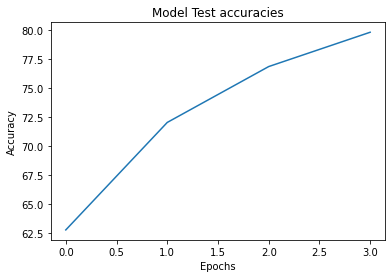

In [15]:
fig, ax = plt.subplots()
ax.plot(accuracies)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Model Test accuracies')
plt.savefig('Accuracies-Quiz.png')
plt.show()

In [16]:
total_params = sum(param.numel() for name, param in  model.named_parameters())


In [17]:
readme = f'''

# Readme file for Quiz

This notebook implements CIFAR10 classification using ResNet NN architecture using PyTorch 

Here we use Data Augmentation implementusing [Albumentations](https://github.com/albumentations-team/albumentations) library

The results with using QuizDNN are as follows. The QuizDNN definition is in `model/QuizDNN.py` file
 
----
| Attribute | Value |
|:--- | :--- |
| Test Accuracy | {np.max(accuracies)} |
| Trained Parameter count   |{total_params} |
| Dropout | {DROPOUT} |
| Total Epochs | {EPOCHS} |
| Batch Size | {TRAIN_BATCH_SIZE}|

----

![](Accuracies-Quiz.png)

The model uses:
* 3x3 Convolution
* Batch Normalization
* Max Pooling
* 4 X Residual networks of size 2 

To run 

You can install dependencies using  
`$ pip install -r req.txt`

'''

with open('README-Quiz.md', 'w') as f:
    f.write(readme)

In [18]:
!ls 'w9-Data Augmentation'

ls: cannot access 'w9-Data Augmentation': No such file or directory
